There has been lots of talking about diversity in the workplace, especially in technology. The Head of HR at your company is very concerned about that and has asked you to analyze internal data about employees and see whether results suggest that the company is treating its employees fairly.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import chi2
import xgboost as xgb

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Index
* __Answer question 1__
* __Answer question 2__
* __Answer-question 3__
    * Load all the data
    * Feature Enginnering
    * Remove outliers
    * Train
    * Evaluate
* __Answer question 4__
    * Main factors impacting salaries
    * Residuals Analysis
    * Is it fair? Any bias?
    * Suggestions to HR header
    
# Answer question 1  
In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.

* Individual Contributors (IC) - they don't manage anyone
* Middle Managers (MM) - they are the direct bosses of IC
* Directors (D) - they are the direct bosses of MM
* VP - D direct bosses
* Executives (E) - VP direct bosses
* CEO - The direct boss of E.

In [3]:
hierarchy = pd.read_csv("company_hierarchy.csv",index_col='employee_id')
hierarchy['level'] = None # initialize 

# starting point
hierarchy.loc[hierarchy.dept == 'CEO','level'] = 'CEO'

# change all boss_id to integer
hierarchy.loc[hierarchy.level == 'CEO','boss_id'] = -1
hierarchy['boss_id'] = hierarchy.boss_id.astype(int)

def set_level(boss_level,level):
    boss_ids = hierarchy.loc[hierarchy.level == boss_level,:].index
    is_subordinate = np.in1d(hierarchy.boss_id,boss_ids)
    hierarchy.loc[is_subordinate,'level'] = level

set_level('CEO','E')
set_level('E','VP')
set_level('VP','D')
set_level('D','MM')
set_level('MM','IC')

In [4]:
hierarchy.level.value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

# Answer question 2
How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.



In [5]:
hierarchy['n_subordinates'] = 0 # initialize

def __count_subordinates(s):
    """
    s: stands for subordinates, it is a series
    its value represents #subordinates that subordinate has
    """
    n_direct_subordinates = s.shape[0]
    n_indirect_subordinates = s.sum()
    return n_direct_subordinates + n_indirect_subordinates

def count_subordinates(subordinate_level):
    num_subordinates = hierarchy.loc[hierarchy.level == subordinate_level,:].groupby('boss_id')['n_subordinates'].agg(__count_subordinates)
    hierarchy.loc[num_subordinates.index,'n_subordinates'] = num_subordinates

count_subordinates(subordinate_level="IC")
count_subordinates(subordinate_level="MM")
count_subordinates(subordinate_level="D")
count_subordinates(subordinate_level="VP")
count_subordinates(subordinate_level="E")

In [6]:
# CEO's n_subordinates is all employees but himself
hierarchy.loc[hierarchy.level =='CEO','n_subordinates']

employee_id
61554    9999
Name: n_subordinates, dtype: int64

# Answer question 3
Build a model to predict the salary of each employee.
## Load all the data

In [7]:
employees = pd.read_csv("employee.csv",index_col="employee_id")

# make the salary "N k", where k represents $1000, which is easier to display
employees["salary"] /= 1000

In [8]:
# join all features together
employees = employees.join(hierarchy)

In [9]:
employees.to_csv("all_employees.csv",index_label="employee_id")

## Feature Enginnering

In [10]:
X = employees.copy()

X["is_male"] = (X.sex == "M").astype(int)
del X["sex"]

del X['boss_id']# I assume boss_id won't affect salary

In [11]:
# transform 'level' into numbers
# !!! ORDER matters
index2level = ['IC','MM',"D","VP","E","CEO"]
level2index = {l:index for index,l in enumerate(index2level)}
X['level'] = X.level.map(level2index)

In [12]:
# transform 'educational degree' into numbers
# !!! ORDER matters
index2degree = ['High_School','Bachelor','Master','PhD']
degree2index = {d:index for index,d in enumerate(index2degree)}
X['degree'] = X.degree_level.map(degree2index)
del X['degree_level']

In [13]:
# OHE department
X = pd.get_dummies(X)
del X['dept_CEO']

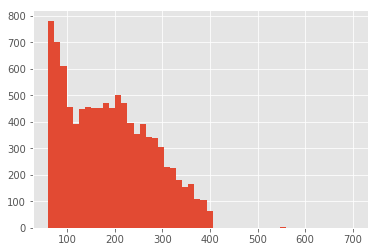

In [14]:
X.salary.hist(bins=50)

from above plot, we can see that, salary's distribution is highly skewed , which increase difficulty on regression. so I need log transform on the target value .

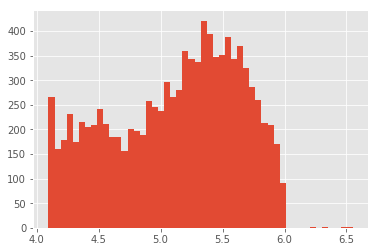

In [15]:
X['salary'] = np.log(X.salary)
X.salary.hist(bins=50)

we can see after log transformation, salary's distribution is more balanced .

In [16]:
X.head()# glance the data

,signing_bonus,salary,yrs_experience,level,n_subordinates,is_male,degree,dept_HR,dept_engineering,dept_marketing,dept_sales
employee_id,,,,,,,,,,,
138719,0,5.609472,2,0,0,1,2,0,1,0,0
3192,0,5.707110,1,0,0,0,1,0,0,0,1
114657,0,5.564520,2,0,0,0,2,0,0,0,1
29039,0,4.454347,4,0,0,0,0,1,0,0,0
118607,0,4.836282,3,0,0,0,1,0,0,0,1


## Remove outliers

In [17]:
X.groupby('level')['salary'].agg(['count','mean'])

,count,mean
level,,
0,9000,5.112835
1,800,5.136089
2,160,5.256181
3,35,5.496709
4,4,6.327854
5,1,6.551080


from above result, we can see there is only one CEO, and his salary is much higher than any other employees in this company.

when I split the data into training/test sets, no matter which set contains CEO, his high salary will impact significantly the training or evaluation. so I consider CEO as outlier, and remove it from the data set.

In [18]:
X = X.loc[X.level !=5,:]

## Train

In [19]:
y = X['salary']
del X['salary']

In [20]:
seed = 999
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=seed)

In [21]:
Xtrain.level.value_counts()

0    6321
1     541
2     110
3      25
4       2
Name: level, dtype: int64

In [22]:
Xtest.level.value_counts()

0    2679
1     259
2      50
3      10
4       2
Name: level, dtype: int64

we can see that, after splitting, even the smallest group 'level=4' (i.e., Executive level), has representives in ** both ** groups. Hence, the splitting is valid to be used to train and evaluate.

In [23]:
train_matrix = xgb.DMatrix(Xtrain,ytrain)
test_matrix = xgb.DMatrix(Xtest)

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [31]:
params = {}
params['silent'] = 1
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
# params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)

[0]	train-rmse:4.18653+0.00241745	test-rmse:4.18659+0.0102357
[1]	train-rmse:3.77208+0.00237267	test-rmse:3.77222+0.00950184
[2]	train-rmse:3.39988+0.0022304	test-rmse:3.40004+0.00917052
[3]	train-rmse:3.06509+0.00197006	test-rmse:3.06526+0.00893588
[4]	train-rmse:2.76431+0.0018755	test-rmse:2.76447+0.00868091
[5]	train-rmse:2.49394+0.00168466	test-rmse:2.49404+0.00835074
[6]	train-rmse:2.25141+0.00133889	test-rmse:2.25151+0.00845141
[7]	train-rmse:2.03338+0.00135002	test-rmse:2.03347+0.00809405
[8]	train-rmse:1.83809+0.0012959	test-rmse:1.83817+0.00794418
[9]	train-rmse:1.66323+0.00120764	test-rmse:1.66332+0.00780151
[10]	train-rmse:1.50686+0.00130183	test-rmse:1.50691+0.00763602
[11]	train-rmse:1.36682+0.00158972	test-rmse:1.36685+0.00741369
[12]	train-rmse:1.24215+0.00149622	test-rmse:1.24215+0.00750964
[13]	train-rmse:1.13097+0.00154694	test-rmse:1.13097+0.00756412
[14]	train-rmse:1.03189+0.0015821	test-rmse:1.03197+0.00740497
[15]	train-rmse:0.944358+0.00137927	test-rmse:0.944592+

In [30]:
n_best_trees = cv_results.shape[0]
n_best_trees

51

In [31]:
# re-train on all the data
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[0]	train-rmse:4.18652
[1]	train-rmse:3.7718
[2]	train-rmse:3.39932
[3]	train-rmse:3.06434
[4]	train-rmse:2.76352
[5]	train-rmse:2.49273
[6]	train-rmse:2.25002
[7]	train-rmse:2.03231
[8]	train-rmse:1.83711
[9]	train-rmse:1.66222
[10]	train-rmse:1.50532
[11]	train-rmse:1.36565
[12]	train-rmse:1.24103
[13]	train-rmse:1.12989
[14]	train-rmse:1.03101
[15]	train-rmse:0.943081
[16]	train-rmse:0.865721
[17]	train-rmse:0.79734
[18]	train-rmse:0.737224
[19]	train-rmse:0.684708
[20]	train-rmse:0.638901
[21]	train-rmse:0.599115
[22]	train-rmse:0.565053
[23]	train-rmse:0.535792
[24]	train-rmse:0.510952
[25]	train-rmse:0.489895
[26]	train-rmse:0.472119
[27]	train-rmse:0.457203
[28]	train-rmse:0.444277
[29]	train-rmse:0.433795
[30]	train-rmse:0.424983
[31]	train-rmse:0.417599
[32]	train-rmse:0.411552
[33]	train-rmse:0.406432
[34]	train-rmse:0.402177
[35]	train-rmse:0.398585
[36]	train-rmse:0.395641
[37]	train-rmse:0.393354
[38]	train-rmse:0.391396
[39]	train-rmse:0.389621
[40]	train-rmse:0.388394
[4

## Evaluate

In [32]:
ytest_pred = gbt.predict(test_matrix, ntree_limit=n_best_trees)
np.sqrt(mean_squared_error(ytest,ytest_pred))

0.39424478072226654

we can see that, training RMSE is 0.38, and test set has RMSE 0.39, the difference isn't very high.

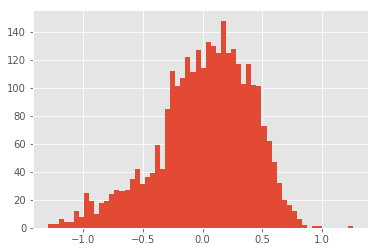

In [33]:
# check residual's distribution
(ytest - ytest_pred).hist(bins=60)

from above plot, we can see residuals' distribution is nearly normal, although a little skewed. Hence, the trained model is acceptable.

In [35]:
gbt.save_model('gbt.model')

# Answer question 4
* Describe the main factors impacting employee salaries.
* Do you think the company has been treating its employees fairly? Do you see any bias?
* What are the next steps you would suggest to the Head of HR?

## Main factors impacting salaries

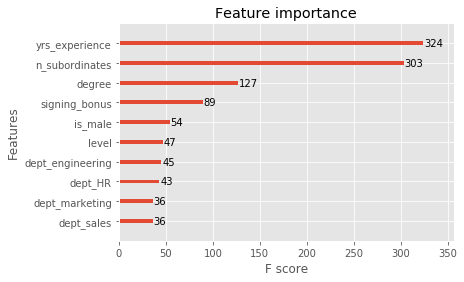

In [36]:
xgb.plot_importance(gbt)

from above plot of feature importance, we can see the main factors impacting salaries includes:

* "years of experience". this is fair, more experienced deserve high salary
* 'n_subordinates'. #subordinates has some relationship with level. higher level, more subordinates, more salary

## Residuals Analysis

In [43]:
# predict on all data (except CEO) and calculate the bias
whole_matrix = xgb.DMatrix(X)
ypred = gbt.predict(whole_matrix)

# since our prediction is log(salary), so we need to exp it to get the original salary (unit: k)
predresult = pd.DataFrame({'ytrue': np.exp(y),'ypred': np.exp(ypred)})

# if bias >0, means, that employee is over paid
# otherwise, bias<0, means that employee is under paid
predresult['bias'] = predresult.ytrue - predresult.ypred

In [44]:
# join with employee's features
predresult = predresult.join(employees)
predresult.head() # glance

,ytrue,ypred,bias,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level,n_subordinates
employee_id,,,,,,,,,,,,
138719,273.0,219.576401,53.423599,0,273.0,Master,M,2,43602,engineering,IC,0
3192,301.0,168.047165,132.952835,0,301.0,Bachelor,F,1,87847,sales,IC,0
114657,261.0,172.140106,88.859894,0,261.0,Master,F,2,180854,sales,IC,0
29039,86.0,79.937775,6.062225,0,86.0,High_School,F,4,88370,HR,IC,0
118607,126.0,173.645401,-47.645401,0,126.0,Bachelor,F,3,23565,sales,IC,0


In [45]:
del predresult['ytrue'] # redundant with salary

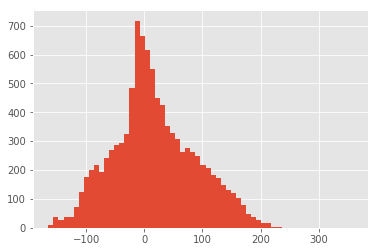

In [46]:
predresult.bias.hist(bins=60)

bias is nearly normal.

Text(0, 0.5, 'bias')

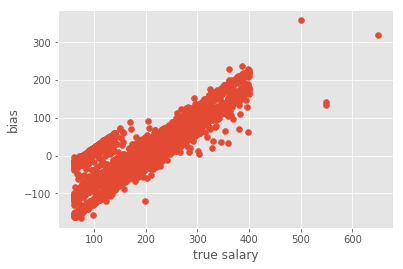

In [47]:
plt.scatter(predresult.salary,predresult.bias)
plt.xlabel("true salary")
plt.ylabel("bias")

from above plot, we can see that, employee with high salary are more likely to be overpaid.

In [48]:
def chisquare_test_on_bias():
    X = predresult.copy()
    del X['ypred']
    del X['salary']
    del X['boss_id']

    X['degree_level'] = X.degree_level.map(degree2index)
    X['level'] = X.level.map(level2index)

    X['is_male'] = (X.sex == 'M').astype(int)
    del X['sex']

    dept_lb_encoder = LabelEncoder()
    X['dept'] = dept_lb_encoder.fit_transform(X.dept)
    
    y = (X.bias > 0)
    del X['bias']
    
    scores,pvalues = chi2(X,y)
    return pd.DataFrame({'score': scores, 'pvalue': pvalues},index = X.columns).sort_values(by='pvalue')

In [49]:
chisquare_test_on_bias()

,score,pvalue
n_subordinates,4755.544500,0.000000
dept,18.641300,0.000016
level,3.377042,0.066111
yrs_experience,1.522935,0.217176
signing_bonus,1.348374,0.245562
is_male,0.987238,0.320418
degree_level,0.373946,0.540861


n_subordinates, department, level are three factors impacting whether the employee is overpaid or underpaid.

Text(0, 0.5, 'bias')

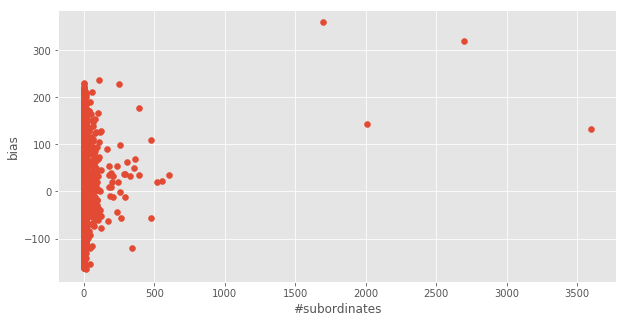

In [51]:
plt.figure(figsize=(10,5))
plt.scatter(predresult.n_subordinates,predresult.bias)
plt.xlabel("#subordinates")
plt.ylabel("bias")

from above plot, we can see that, more subordinates (i.e., higher level), more positive bias, means more likely to be overpaid.

## Is it fair? Any bias?
I think, in large scope, the company treat its employee fairly. the difference among different sex and departments seems normal and fair enough.

the only bias I can see is that, the management level is likely to be overpaid. Higher the level, more likely to be overpaid.

# Suggestions to HR header
I may suggest him/her considering lower down the salaries in high management level , which may be more fair to the workforce.